# Tutorial on DTM surface area and slope statistics

Import all necessary modules, especially all our surface area related functions inside the name space `sa`.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from scipy.integrate import dblquad
from scipy.stats import gaussian_kde
from tqdm import trange

import surface_area as sa

pl.rcParams["figure.dpi"] = 200

We provide two synthetic landscape types. One very smooth and constructed from 2D Gaussian functions, and another more rough and hilly consisting of a superposition of Sine and Cosine functions in 2D:

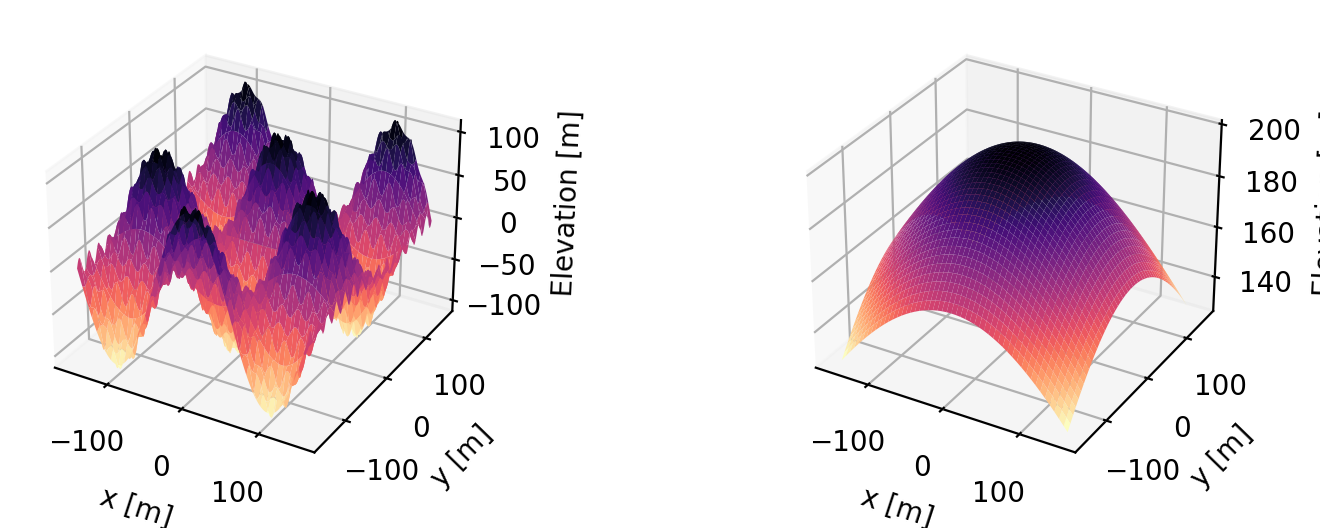

In [6]:
# DTM resolution
resolution = 1
xr = np.arange(-150, 150, resolution)
yr = xr

# synthetic landscape coordinates
x, y = np.meshgrid(xr, yr)

# Cos Sin DTM
dtm_sincos = sa.synthetic_landscape(x, y, landscape_type="sincos", amplitude=100)

# Gaussian hill DTM
dtm_hill = sa.synthetic_landscape(x, y, landscape_type="hill", amplitude=200)

# visuals
fg, ax = pl.subplots(1, 2, figsize=(9, 3), subplot_kw={"projection": "3d"})
for i, dtm in enumerate((dtm_sincos, dtm_hill)):
    ax[i].plot_surface(x, y, dtm, cmap="magma_r")
    ax[i].set_xlabel("x [m]")
    ax[i].set_ylabel("y [m]")
    ax[i].set_zlabel("Elevation [m]")
pl.show()

For these synthetic landscapes we can also retrieve analytical slopes:

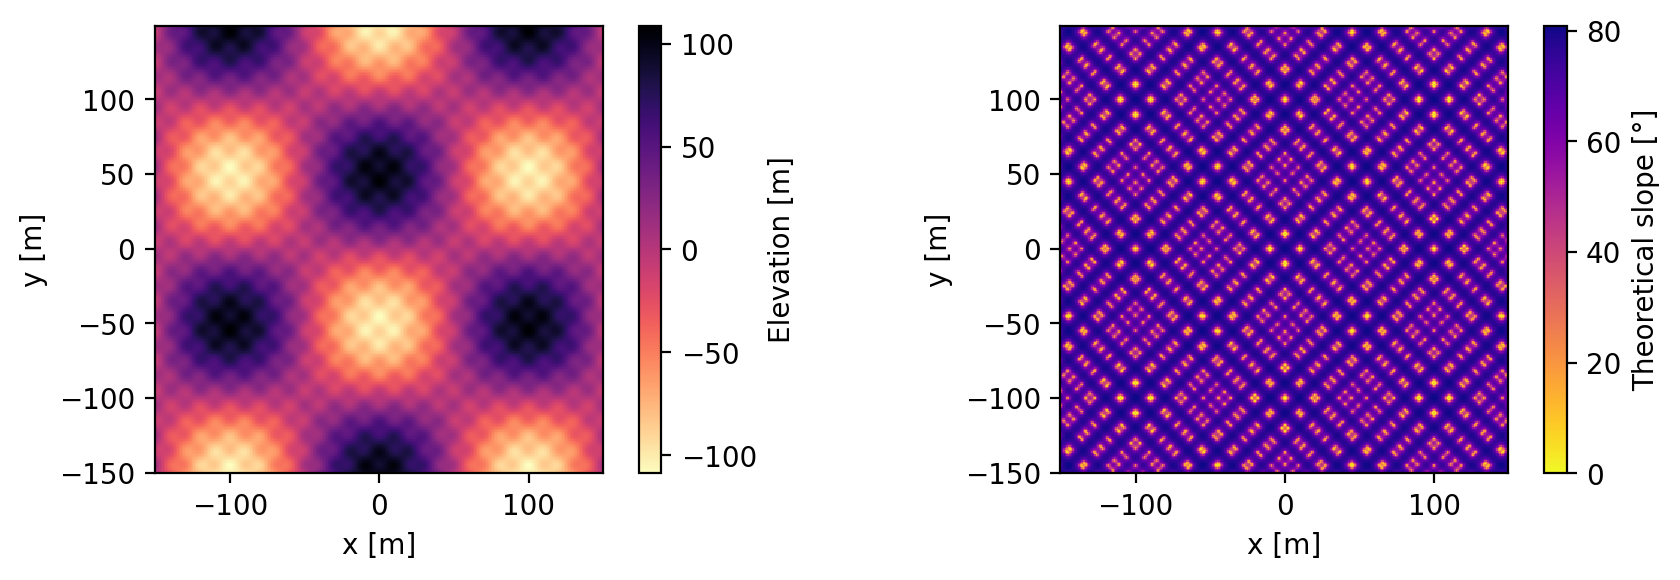

In [7]:
dtm = dtm_sincos

# theoretical slope
slp = (
    180
    / np.pi
    * sa.synthetic_landscape_slope(x, y, landscape_type="sincos", amplitude=100)
)

fg, ax = pl.subplots(1, 2, figsize=(9, 3))
im = ax[0].pcolormesh(x, y, dtm, cmap="magma_r")
ax[0].set_xlabel("x [m]")
ax[0].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[0])
cb.set_label("Elevation [m]")
im = ax[1].pcolormesh(x, y, slp, cmap="plasma_r")
ax[1].set_xlabel("x [m]")
ax[1].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[1])
cb.set_label("Theoretical slope [°]")
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
pl.tight_layout()
pl.show()

And we can compare these *true* analytical slopes to those numerically estimated at a given resolution using gradient estimation:

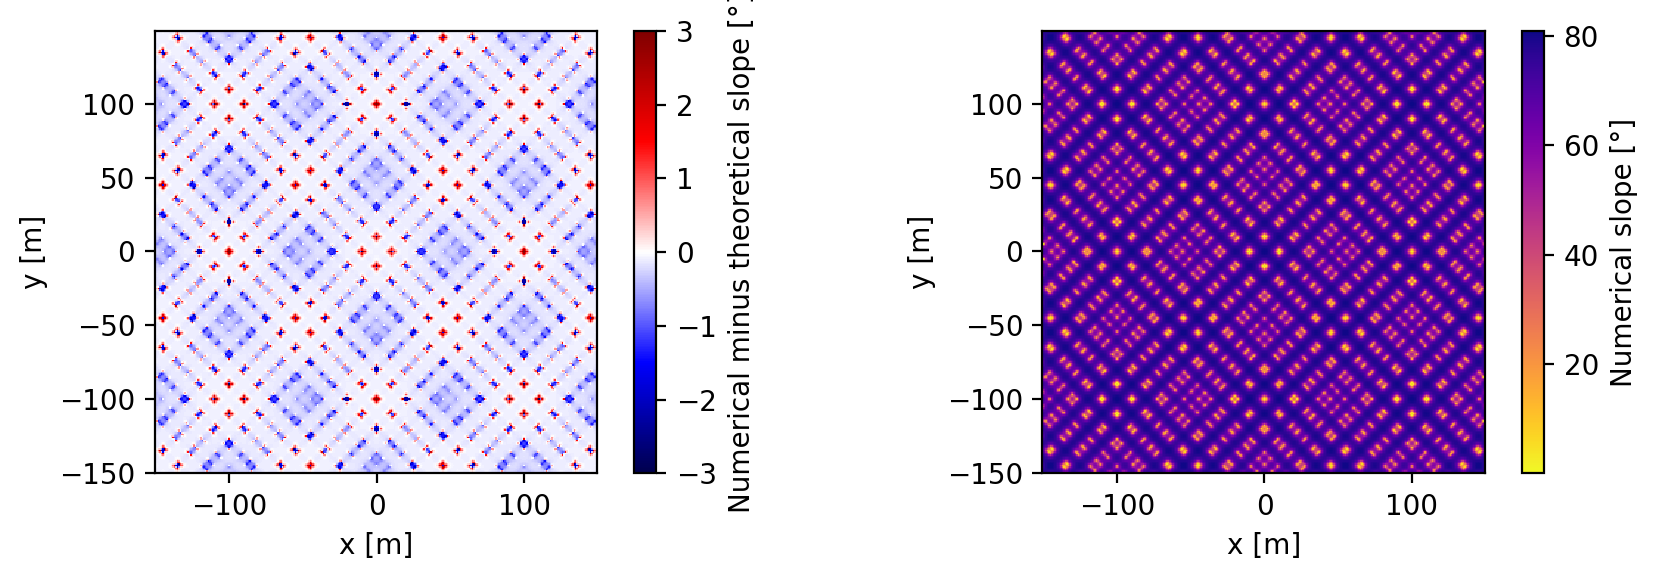

In [8]:
# numerical slope
dy, dx = np.gradient(dtm, resolution)
nslp = 180 / np.pi * np.arctan(np.sqrt(dx * dx + dy * dy))

fg, ax = pl.subplots(1, 2, figsize=(9, 3))
im = ax[0].pcolormesh(x, y, nslp - slp, vmin=-3, vmax=3, cmap="seismic")
ax[0].set_xlabel("x [m]")
ax[0].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[0])
cb.set_label("Numerical minus theoretical slope [°]")
im = ax[1].pcolormesh(x, y, nslp, cmap="plasma_r")
ax[1].set_xlabel("x [m]")
ax[1].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[1])
cb.set_label("Numerical slope [°]")
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
pl.tight_layout()
pl.show()

For this landscape, errors are largest for small slopes, i.e., for ridge crests as well as valley bottoms:

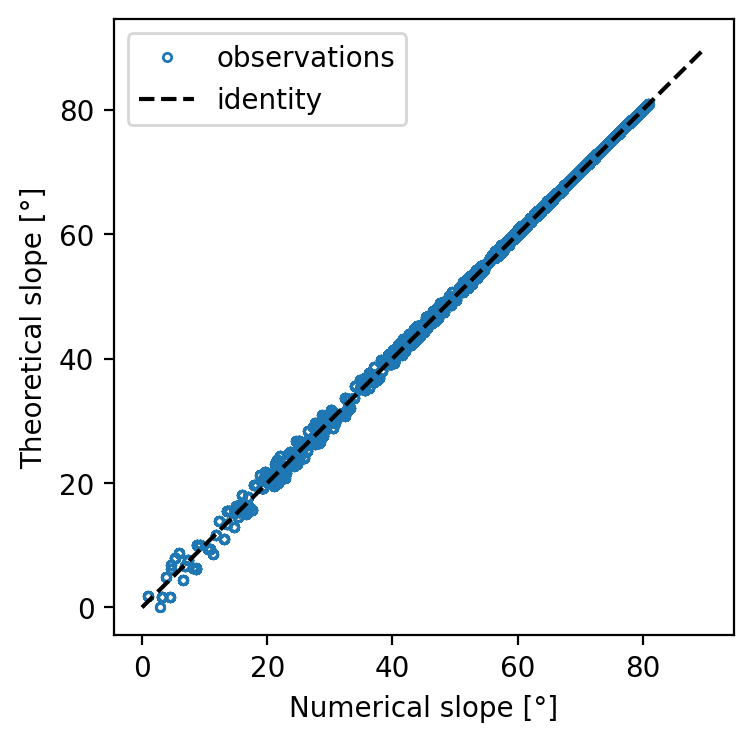

In [9]:
fg, ax = pl.subplots(figsize=(4, 4))
ax.plot(
    nslp[1:-1, 1:-1].ravel(),
    slp[1:-1, 1:-1].ravel(),
    ".",
    mfc="none",
    label="observations",
)
ax.plot([0, 90], [0, 90], "k--", label="identity")
ax.set_xlabel("Numerical slope [°]")
ax.set_ylabel("Theoretical slope [°]")
pl.legend()
pl.show()

We also provide two different approaches to numerical surface area estimation on DTMs. The TINi-based approach by *Jennes et al.*, as well as our COSi-based approach:

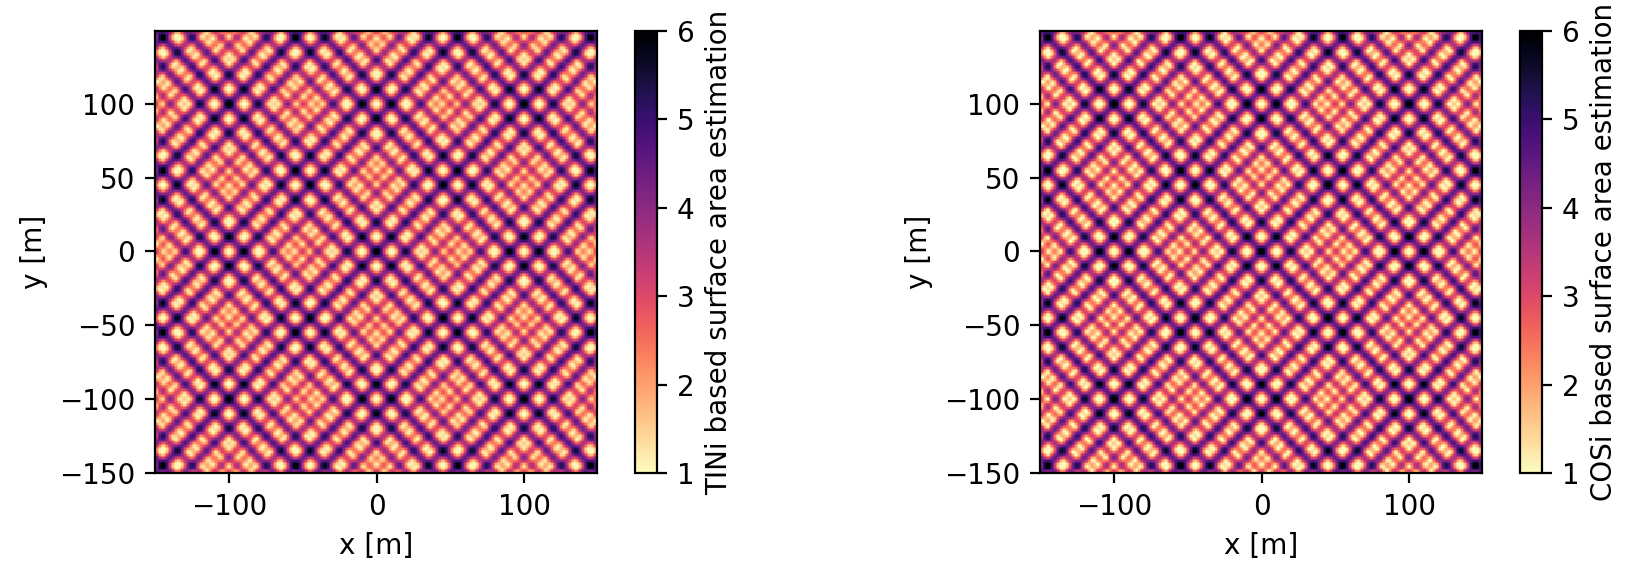

In [10]:
# TIN based surface area according to Jennes et al.
sa_tin = sa.surface_area_tin(dtm, resolution)

# COS based surface area according to our method
sa_cos = sa.surface_area_cos(dtm, resolution)

fg, ax = pl.subplots(1, 2, figsize=(9, 3))
im = ax[0].pcolormesh(x, y, sa_tin, vmin=1, vmax=6, cmap="magma_r")
ax[0].set_xlabel("x [m]")
ax[0].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[0])
cb.set_label("TINi based surface area estimation")
im = ax[1].pcolormesh(x, y, sa_cos, vmin=1, vmax=6, cmap="magma_r")
ax[1].set_xlabel("x [m]")
ax[1].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[1])
cb.set_label("COSi based surface area estimation")
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
pl.tight_layout()
pl.show()

For synthetic landscapes that have a functional form we can as well numerically compute the *true* surface area of each pixel by numerical integration:

In [11]:
# theoretical surface area using numerical integration
sa_num = sa.synthetic_landscape_surface_area(x, y, landscape_type="sincos", amplitude=100)

100%|███████████████████████████████| 300/300 [06:42<00:00,  1.34s/it]


Our approach (COSi) has overall lower error magnitudes and consistently underestimates pixel-wise surface areas. The TINi-based approach does over- as well as underestimate surface areas and has generally larger errors:

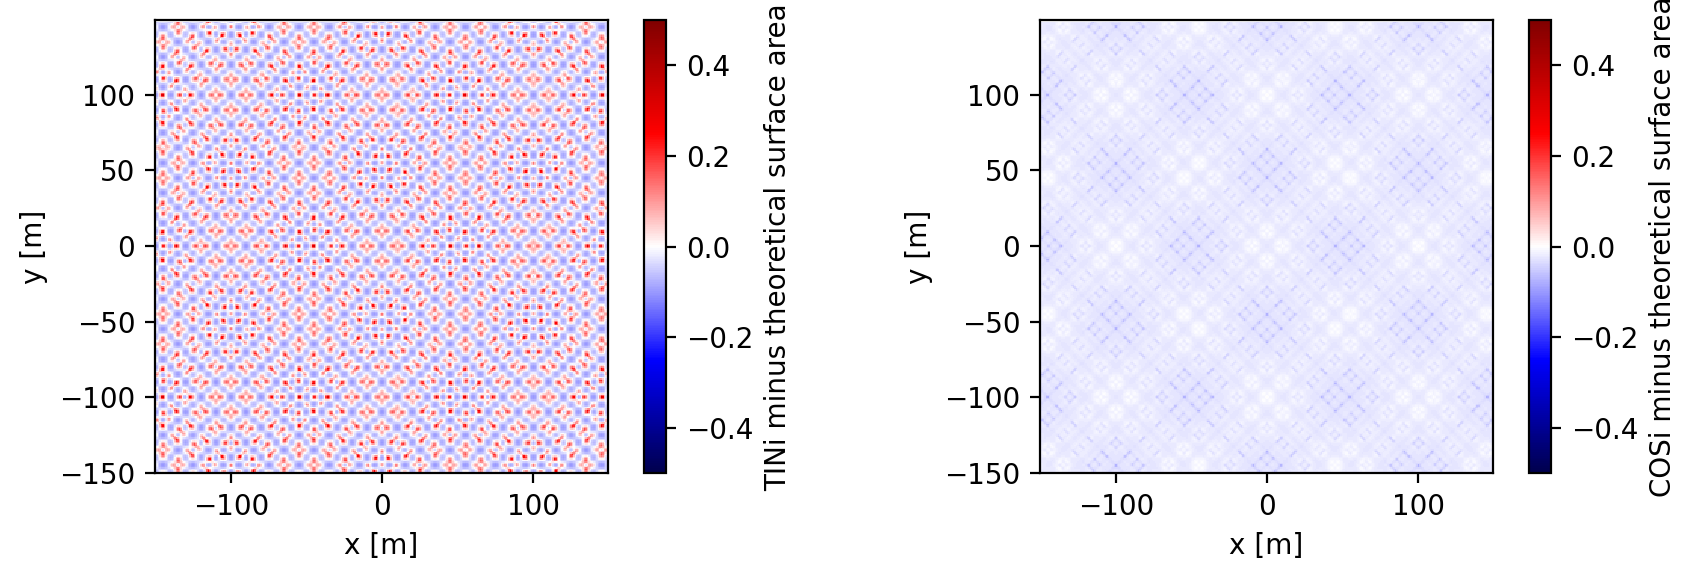

In [12]:
sa_num[0, :] = np.nan
sa_num[-1, :] = np.nan
sa_num[:, 0] = np.nan
sa_num[:, 0 - 1] = np.nan

fg, ax = pl.subplots(1, 2, figsize=(9, 3))
im = ax[0].pcolormesh(x, y, sa_tin - sa_num, vmin=-0.5, vmax=0.5, cmap="seismic")
ax[0].set_xlabel("x [m]")
ax[0].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[0])
cb.set_label("TINi minus theoretical surface area")
im = ax[1].pcolormesh(x, y, sa_cos - sa_num, vmin=-0.5, vmax=0.5, cmap="seismic")
ax[1].set_xlabel("x [m]")
ax[1].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[1])
cb.set_label("COSi minus theoretical surface area")
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
pl.tight_layout()
pl.show()

The higher spread in surface area errors of the TINi approach can also be seen in a scatter plot:

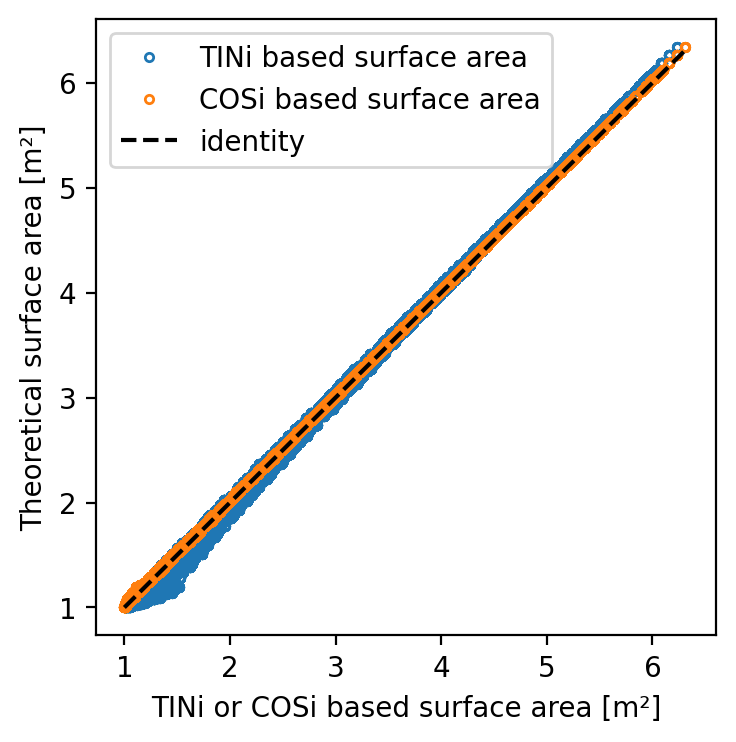

In [13]:
fg, ax = pl.subplots(figsize=(4, 4))
ax.plot(
    sa_tin[1:-1, 1:-1].ravel(),
    sa_num[1:-1, 1:-1].ravel(),
    ".",
    mfc="none",
    label="TINi based surface area",
)
ax.plot(
    sa_cos[1:-1, 1:-1].ravel(),
    sa_num[1:-1, 1:-1].ravel(),
    ".",
    mfc="none",
    label="COSi based surface area",
)
ax.plot([1, np.nanmax(sa_num)], [1, np.nanmax(sa_num)], "k--", label="identity")
ax.set_xlabel("TINi or COSi based surface area [m²]")
ax.set_ylabel("Theoretical surface area [m²]")
pl.legend()
pl.show()

The COSi approach is consistently underestimating surface area, because the surface of each pixel is approximated by a single plain which ignores curvatures within a pixel. However, the TINi approach is using eight triangles for each pixel which can overestimate the surface area of a pixel, especially for shallow pixels:

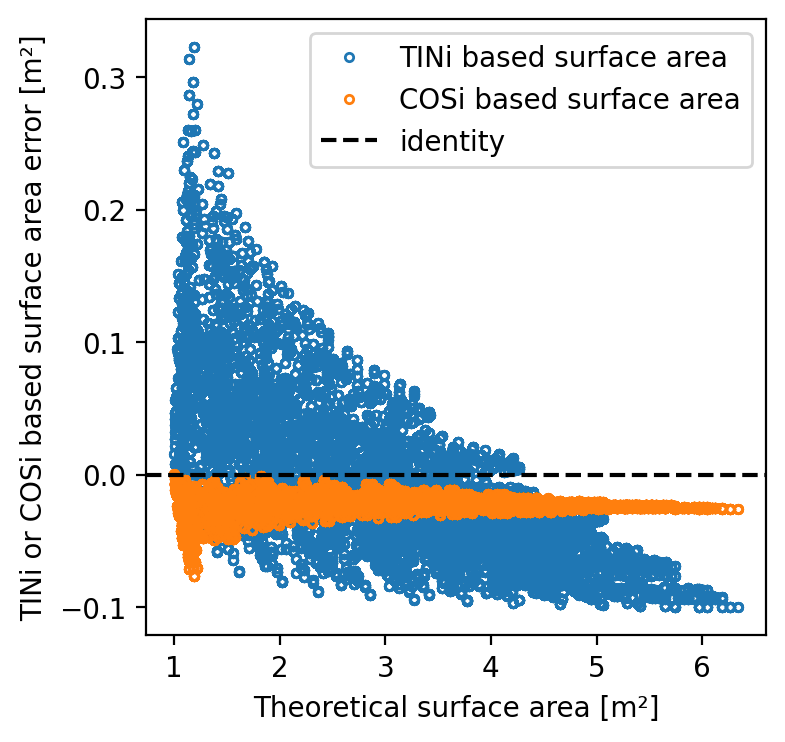

In [14]:
fg, ax = pl.subplots(figsize=(4, 4))
ax.plot(
    sa_num[1:-1, 1:-1].ravel(),
    sa_tin[1:-1, 1:-1].ravel() - sa_num[1:-1, 1:-1].ravel(),
    ".",
    mfc="none",
    label="TINi based surface area",
)
ax.plot(
    sa_num[1:-1, 1:-1].ravel(),
    sa_cos[1:-1, 1:-1].ravel() - sa_num[1:-1, 1:-1].ravel(),
    ".",
    mfc="none",
    label="COSi based surface area",
)
ax.axhline(y=0, color="k", linestyle="--", label="identity")
ax.set_ylabel("TINi or COSi based surface area error [m²]")
ax.set_xlabel("Theoretical surface area [m²]")
pl.legend()
pl.show()

Given theoretically defined synthetic landscapes, we can estimate surface area errors for arbitrary resolutions and study the convergence of the TINi as well as our COSi method:

In [11]:
resolutions = np.logspace(np.log10(0.2), np.log10(20), 20)
da_tin = np.zeros((len(resolutions), 4))
da_cos = np.zeros((len(resolutions), 4))
for i, resolution in enumerate(resolutions):
    print("step", i, ", resolution:", resolution)
    xr = np.arange(resolution/2, 150, resolution)
    yr = xr
    x, y = np.meshgrid(xr, yr)
    dtm = sa.synthetic_landscape(x, y, landscape_type="sincos", amplitude=100)
    x, y = x[1:-1, 1:-1], y[1:-1, 1:-1]
    sa_tin = sa.surface_area_tin(dtm, resolution)[1:-1, 1:-1].ravel()
    sa_cos = sa.surface_area_cos(dtm, resolution)[1:-1, 1:-1].ravel()
    sa_num = sa.synthetic_landscape_surface_area(x, y, landscape_type="sincos", amplitude=100).ravel()
    sa_tin_err = sa_tin - sa_num
    sa_cos_err = sa_cos - sa_num
    da_tin[i, 0] = np.abs(sa_tin_err).mean()
    da_tin[i, 1] = np.abs(sa_tin_err).std()
    da_tin[i, 2] = sa_tin_err.mean()
    da_tin[i, 3] = sa_tin_err.std()
    da_cos[i, 0] = np.abs(sa_cos_err).mean()
    da_cos[i, 1] = np.abs(sa_cos_err).std()
    da_cos[i, 2] = sa_cos_err.mean()
    da_cos[i, 3] = sa_cos_err.std()

step 0 , resolution: 0.20000000000000004


100%|███████████████████████████████| 748/748 [40:04<00:00,  3.21s/it]


step 1 , resolution: 0.25485499714062676


100%|███████████████████████████████| 587/587 [24:38<00:00,  2.52s/it]


step 2 , resolution: 0.3247553478377444


100%|███████████████████████████████| 460/460 [15:18<00:00,  2.00s/it]


step 3 , resolution: 0.413827616222958


100%|███████████████████████████████| 360/360 [09:35<00:00,  1.60s/it]


step 4 , resolution: 0.5273301797460717


100%|███████████████████████████████| 282/282 [05:42<00:00,  1.21s/it]


step 5 , resolution: 0.6719636572567564


100%|███████████████████████████████| 221/221 [03:41<00:00,  1.00s/it]


step 6 , resolution: 0.8562664797438788


100%|███████████████████████████████| 173/173 [02:13<00:00,  1.30it/s]


step 7 , resolution: 1.0911189562337038


100%|███████████████████████████████| 135/135 [01:17<00:00,  1.74it/s]


step 8 , resolution: 1.3903855923551212


100%|███████████████████████████████| 106/106 [00:48<00:00,  2.19it/s]


step 9 , resolution: 1.7717335808201653


100%|█████████████████████████████████| 83/83 [00:29<00:00,  2.85it/s]


step 10 , resolution: 2.257675783369378


100%|█████████████████████████████████| 64/64 [00:17<00:00,  3.74it/s]


step 11 , resolution: 2.876899776575326


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.57it/s]


step 12 , resolution: 3.6659614216648717


100%|█████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


step 13 , resolution: 4.671442938180244


100%|█████████████████████████████████| 30/30 [00:06<00:00,  4.35it/s]


step 14 , resolution: 5.952702883262636


100%|█████████████████████████████████| 23/23 [00:06<00:00,  3.31it/s]


step 15 , resolution: 7.585380381464501


100%|█████████████████████████████████| 18/18 [00:06<00:00,  2.63it/s]


step 16 , resolution: 9.665860477143505


100%|█████████████████████████████████| 14/14 [00:08<00:00,  1.61it/s]


step 17 , resolution: 12.316964221320523


100%|█████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]


step 18 , resolution: 15.695199407029223


100%|███████████████████████████████████| 8/8 [00:08<00:00,  1.07s/it]


step 19 , resolution: 20.000000000000004


100%|███████████████████████████████████| 5/5 [00:05<00:00,  1.20s/it]


In [12]:
np.savez("Surface_area_errors_sincos_landscape.npz", da_tin=da_tin, da_cos=da_cos)

The surface area errors for the Cos Sin landscape are generally larger than for the more smooth Gaussian hill. Considering absolute values of surface area errors, the TINi method produces not only a larger spread of error standard deviations across all pixels for a given resolution, but is also generally less accurate (larger mean error). This is not the case if the total surface area is considered. Here, due to over- as well as underestimations, errors average out and produce an overall slightly more accurate estimation. This is due to the symmetry of the landscape, where hill tops are just inverted valley bottoms.

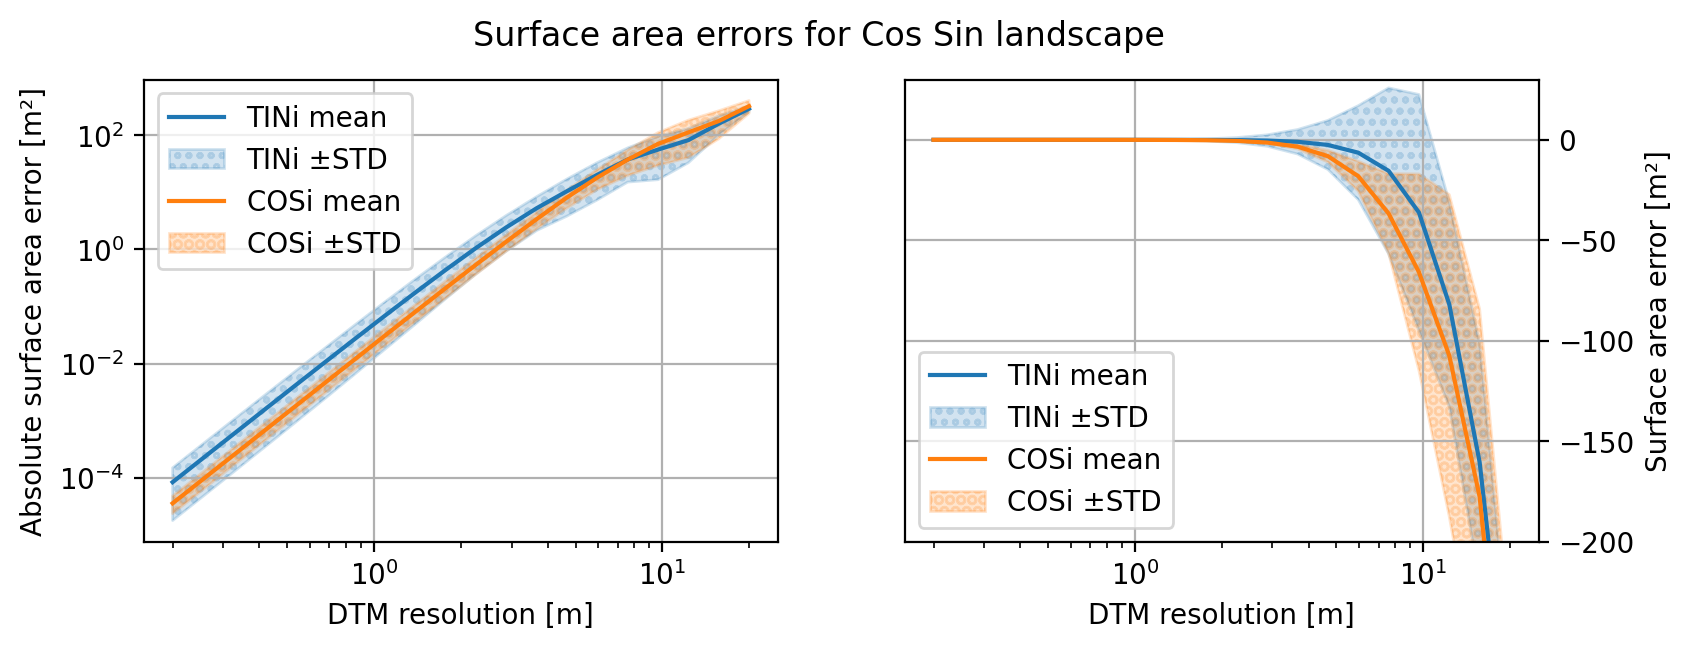

In [29]:
fp = np.load("Surface_area_errors_sincos_landscape.npz")
da_tin = fp["da_tin"]
da_cos = fp["da_cos"]
resolutions = np.logspace(np.log10(0.2), np.log10(20), 20)

fg, ax = pl.subplots(1, 2, figsize=(9, 3))
fg.suptitle("Surface area errors for Cos Sin landscape")
for label, hatch, color, da in zip(("TINi", "COSi"), (r"ooo", r"OOO"), ("tab:blue", "tab:orange"), (da_tin, da_cos)):
    ax[0].loglog(resolutions, da[:, 0], label=label+" mean", color=color)
    ax[0].fill_between(resolutions, da[:, 0] - da[:, 1], da[:, 0] + da[:, 1], color=color, alpha=0.2, hatch=hatch, label=label+" ±STD")
ax[0].set_xlabel("DTM resolution [m]")
ax[0].set_ylabel("Absolute surface area error [m²]")
ax[0].grid()
ax[0].legend()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
# ax[1].set_yscale('symlog', linthresh=1e-3)
ax[1].set_ylim((-200, 30))
for label, hatch, color, da in zip(("TINi", "COSi"), (r"ooo", r"OOO"), ("tab:blue", "tab:orange"), (da_tin, da_cos)):
    ax[1].semilogx(resolutions, da[:, 2], label=label+" mean", color=color)
    ax[1].fill_between(resolutions, da[:, 2] - da[:, 3], da[:, 2] + da[:, 3], color=color, alpha=0.2, hatch=hatch, label=label+" ±STD")
ax[1].set_xlabel("DTM resolution [m]")
ax[1].set_ylabel("Surface area error [m²]")
ax[1].grid()
ax[1].legend()
pl.show()

In [14]:
resolutions = np.logspace(np.log10(0.2), np.log10(20), 20)
da_tin = np.zeros((len(resolutions), 4))
da_cos = np.zeros((len(resolutions), 4))
for i, resolution in enumerate(resolutions):
    print("step", i, ", resolution:", resolution)
    xr = np.arange(resolution/2, 150, resolution)
    yr = xr
    x, y = np.meshgrid(xr, yr)
    dtm = sa.synthetic_landscape(x, y, landscape_type="hill", amplitude=200)
    x, y = x[1:-1, 1:-1], y[1:-1, 1:-1]
    sa_tin = sa.surface_area_tin(dtm, resolution)[1:-1, 1:-1].ravel()
    sa_cos = sa.surface_area_cos(dtm, resolution)[1:-1, 1:-1].ravel()
    sa_num = sa.synthetic_landscape_surface_area(x, y, landscape_type="hill", amplitude=200).ravel()
    sa_tin_err = sa_tin - sa_num
    sa_cos_err = sa_cos - sa_num
    da_tin[i, 0] = np.abs(sa_tin_err).mean()
    da_tin[i, 1] = np.abs(sa_tin_err).std()
    da_tin[i, 2] = sa_tin_err.mean()
    da_tin[i, 3] = sa_tin_err.std()
    da_cos[i, 0] = np.abs(sa_cos_err).mean()
    da_cos[i, 1] = np.abs(sa_cos_err).std()
    da_cos[i, 2] = sa_cos_err.mean()
    da_cos[i, 3] = sa_cos_err.std()
    
np.savez("Surface_area_errors_hill_landscape.npz", da_tin=da_tin, da_cos=da_cos)

step 0 , resolution: 0.20000000000000004


100%|███████████████████████████████| 748/748 [12:42<00:00,  1.02s/it]


step 1 , resolution: 0.25485499714062676


100%|███████████████████████████████| 587/587 [07:57<00:00,  1.23it/s]


step 2 , resolution: 0.3247553478377444


100%|███████████████████████████████| 460/460 [04:56<00:00,  1.55it/s]


step 3 , resolution: 0.413827616222958


100%|███████████████████████████████| 360/360 [03:00<00:00,  1.99it/s]


step 4 , resolution: 0.5273301797460717


100%|███████████████████████████████| 282/282 [01:50<00:00,  2.56it/s]


step 5 , resolution: 0.6719636572567564


100%|███████████████████████████████| 221/221 [01:07<00:00,  3.27it/s]


step 6 , resolution: 0.8562664797438788


100%|███████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


step 7 , resolution: 1.0911189562337038


100%|███████████████████████████████| 135/135 [00:24<00:00,  5.43it/s]


step 8 , resolution: 1.3903855923551212


100%|███████████████████████████████| 106/106 [00:15<00:00,  7.00it/s]


step 9 , resolution: 1.7717335808201653


100%|█████████████████████████████████| 83/83 [00:09<00:00,  8.68it/s]


step 10 , resolution: 2.257675783369378


100%|█████████████████████████████████| 64/64 [00:05<00:00, 11.55it/s]


step 11 , resolution: 2.876899776575326


100%|█████████████████████████████████| 50/50 [00:03<00:00, 14.77it/s]


step 12 , resolution: 3.6659614216648717


100%|█████████████████████████████████| 39/39 [00:02<00:00, 18.93it/s]


step 13 , resolution: 4.671442938180244


100%|█████████████████████████████████| 30/30 [00:01<00:00, 24.59it/s]


step 14 , resolution: 5.952702883262636


100%|█████████████████████████████████| 23/23 [00:00<00:00, 31.96it/s]


step 15 , resolution: 7.585380381464501


100%|█████████████████████████████████| 18/18 [00:00<00:00, 39.95it/s]


step 16 , resolution: 9.665860477143505


100%|█████████████████████████████████| 14/14 [00:00<00:00, 51.87it/s]


step 17 , resolution: 12.316964221320523


100%|█████████████████████████████████| 10/10 [00:00<00:00, 71.47it/s]


step 18 , resolution: 15.695199407029223


100%|███████████████████████████████████| 8/8 [00:00<00:00, 88.94it/s]


step 19 , resolution: 20.000000000000004


100%|██████████████████████████████████| 5/5 [00:00<00:00, 166.76it/s]


For the Gaussian hill both methods are very accurate, but the TINi method outperforms the COSi method due to the higher intrinsic resolution of eight triangles per pixel without the possibility to overfit. This is only expected for extremely smooth landscapes.

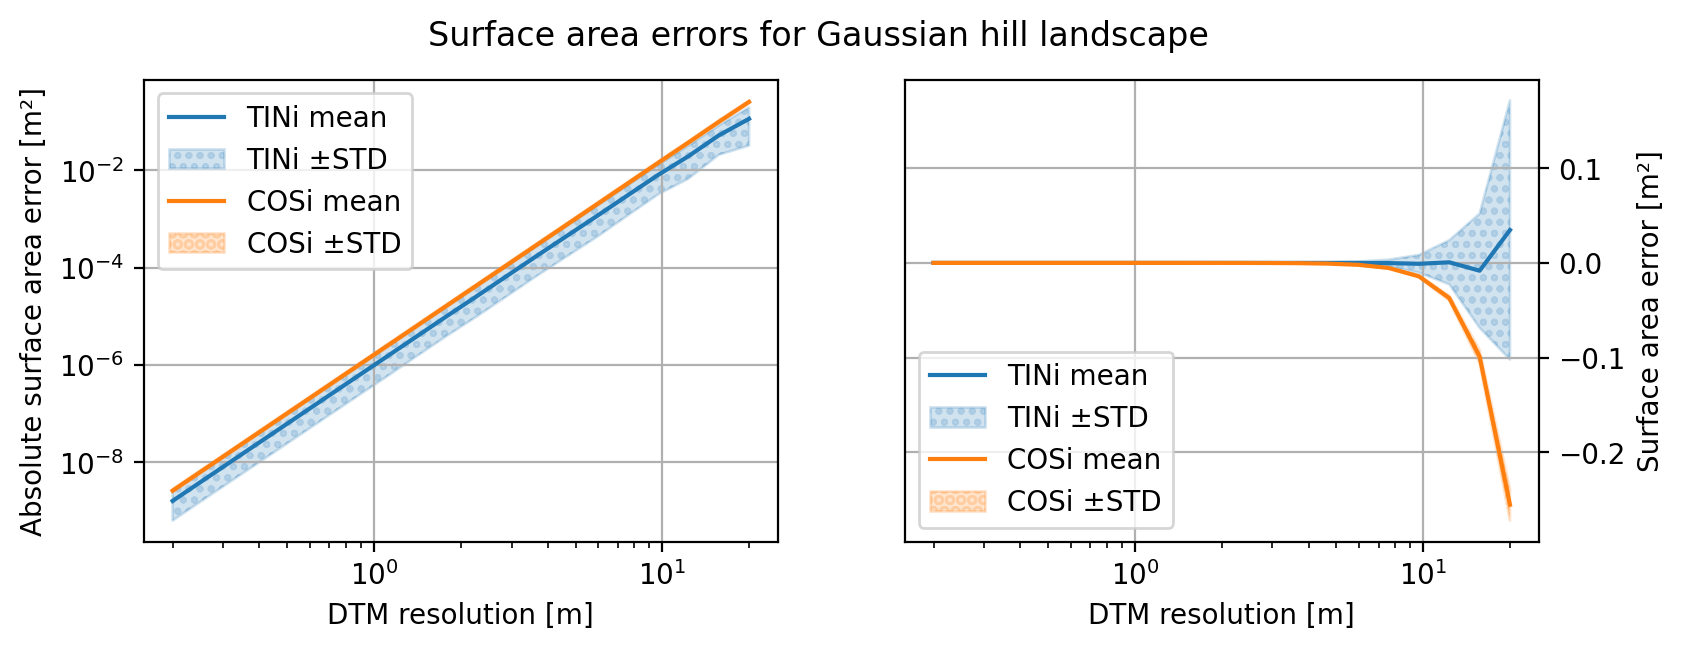

In [28]:
fp = np.load("Surface_area_errors_hill_landscape.npz")
da_tin = fp["da_tin"]
da_cos = fp["da_cos"]
fg, ax = pl.subplots(1, 2, figsize=(9, 3))
fg.suptitle("Surface area errors for Gaussian hill landscape")
for label, hatch, color, da in zip(("TINi", "COSi"), (r"ooo", r"OOO"), ("tab:blue", "tab:orange"), (da_tin, da_cos)):
    ax[0].loglog(resolutions, da[:, 0], label=label+" mean", color=color)
    ax[0].fill_between(resolutions, da[:, 0] - da[:, 1], da[:, 0] + da[:, 1], color=color, alpha=0.2, hatch=hatch, label=label+" ±STD")
ax[0].set_xlabel("DTM resolution [m]")
ax[0].set_ylabel("Absolute surface area error [m²]")
ax[0].grid()
ax[0].legend()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
# ax[1].set_yscale('symlog', linthresh=1e-3)
# ax[1].set_ylim((-200, 30))
for label, hatch, color, da in zip(("TINi", "COSi"), (r"ooo", r"OOO"), ("tab:blue", "tab:orange"), (da_tin, da_cos)):
    ax[1].semilogx(resolutions, da[:, 2], label=label+" mean", color=color)
    ax[1].fill_between(resolutions, da[:, 2] - da[:, 3], da[:, 2] + da[:, 3], color=color, alpha=0.2, hatch=hatch, label=label+" ±STD")
ax[1].set_xlabel("DTM resolution [m]")
ax[1].set_ylabel("Surface area error [m²]")
ax[1].grid()
ax[1].legend()
pl.show()

Given slope and surface area for each pixel in a DTM, one can consider slope distributions or probability density function (PDF) estimates in relation to surface area. The common approach of considering each slope value of each pixel as it is, is considering a planform view. Each pixel counts equal no matter how large its surface area is. In contrast one can also weigh each slope value according to the surface area of the corresponding pixel which takes into account that steep slopes occupy more surface area. This surface area view addresses how much surface area is represented with certain slopes. Most PDF estimation approaches such as histograms or kernel density estimates support weights. Here, we use Gaussian kernel density estimates by SciPy:

In [31]:
# DTM resolution
resolution = 1
xr = np.arange(resolution / 2, 150, resolution)
yr = xr

# synthetic landscape coordinates
x, y = np.meshgrid(xr, yr)

# Sin Cos DTM (can also be a real DTM)
dtm = sa.synthetic_landscape(x, y, landscape_type="sincos", amplitude=100)

# numerical surface area estimation
sar = sa.surface_area_cos(dtm, resolution)

# numerical slope estimation
dy, dx = np.gradient(dtm, resolution)
slp = 180 / np.pi * np.arctan(np.sqrt(dx * dx + dy * dy))

slp = slp[1:-1, 1:-1].ravel()
sar = sar[1:-1, 1:-1].ravel()

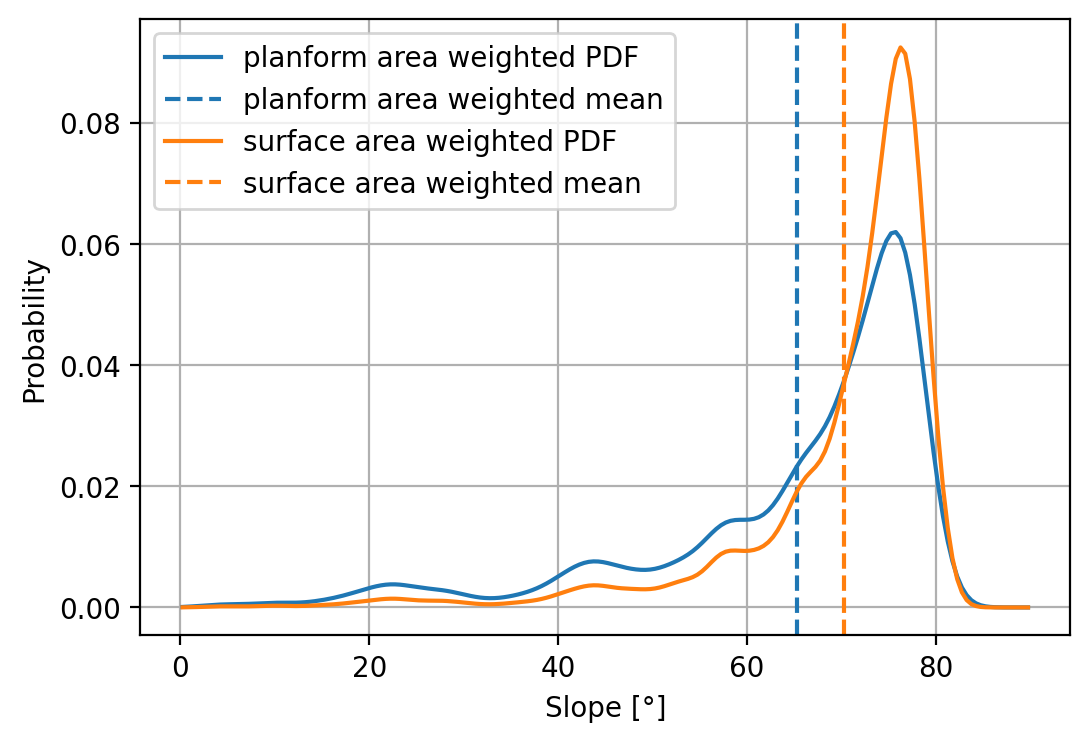

In [32]:
kde_planform = gaussian_kde(slp)
kde_surface = gaussian_kde(slp, weights=sar)
avg_planform = np.average(slp)
avg_surface = np.average(slp, weights=sar)

degrees = np.arange(0.25, 90, 0.5)
fg, ax = pl.subplots(figsize=(6, 4))

ax.plot(degrees, kde_planform.pdf(degrees), label="planform area weighted PDF")
ax.axvline(x=avg_planform, ls="--", label="planform area weighted mean")

ax.plot(degrees, kde_surface.pdf(degrees), label="surface area weighted PDF")
ax.axvline(x=avg_surface, ls="--", color="tab:orange", label="surface area weighted mean")

ax.set_ylabel("Probability")
ax.set_xlabel("Slope [°]")
ax.grid()
pl.legend()
pl.show()